In [1]:
import pandas as pd
import numpy as np
import json
import csv
#1.确定这几个数据都是干什么的
swiping_card_dataframe = pd.read_csv('./bus_swiping_card_info1.csv')
card_info_dataframe = pd.read_csv('./card_info.csv')
bus_swip_dataframe = pd.read_excel('公交数据.xlsx',sheet_name='刷卡数据',header=0,engine='openpyxl')
bus_station_dataframe = pd.read_excel('公交数据.xlsx',sheet_name='站点数据',header=0,engine='openpyxl')
#swiping_card_dataframe ： 每次刷卡的信息：几号线，第几站，车辆的id，刷卡的id，刷卡的时间
#card_info_dataframe ： 每次刷卡的信息：几号线，第几站，车辆的id，刷卡的id，刷卡的时间也是上面的信息，但是时间是去年的。
#用去年的时间的同比数据，去预测今年的同比数据，看是否一致，如果一致，说明经济发展没有变化，如果变大，说明经济好转
#bus_swip_dataframe ：一天的统计信息：各条线路、各个站点的刷卡数量信息
#bus_station_dataframe ： 站点的统计信息：各个站点的经纬度

In [2]:
line_station_number_sequen_dataframe = \
bus_station_dataframe.groupby(['line_identity','station_number']).agg({'station_name':list,'station_identity':list}).reset_index()

line_station_number_sequen_dataframe['length'] = \
line_station_number_sequen_dataframe['station_identity'].apply(lambda x:len(x))

line_station_number_sequen_dataframe

line_station_number_sequen_dataframe['id_station'] = \
line_station_number_sequen_dataframe.apply(lambda x:list(zip(x['station_identity'],x['station_name'])),axis=1)
line_station_number_sequen_dataframe
#获取每条线路上乘客上车站所对应的可能的下车站：估计数据量为：
#构建一个字典：
#road_structure = {line_id:{'stations_nums':int,'stations':{station_id:station_name},'all_stations':[]}}
road_line_station_structure_setting={}
for row_index in range(len(line_station_number_sequen_dataframe)):
    line_id = int(line_station_number_sequen_dataframe[row_index:row_index+1]['line_identity'].values[0])
    stations_nums = int(line_station_number_sequen_dataframe[row_index:row_index+1]['station_number'].values[0])
    all_stations = line_station_number_sequen_dataframe[row_index:row_index+1]['station_name'].values[0]
    stations={}
    for instance in line_station_number_sequen_dataframe[row_index:row_index+1]['id_station'].values[0]:
        instance_id = int(instance[0])
        instance_name = instance[1]
        stations[instance_id]=instance_name
    road_line = {'stations_nums':stations_nums,'stations':stations,'all_stations':all_stations}
    road_line_station_structure_setting[line_id] = road_line
road_line_station_structure_setting

{1: {'stations_nums': 20,
  'stations': {1: '火车站',
   2: '展览馆',
   3: '新路口',
   4: '邮电大楼',
   5: '大十字',
   6: '喷水池',
   7: '云中广场',
   8: '六广门',
   9: '北京路',
   10: '北京西路口',
   11: '黔灵山公园',
   12: '黔灵山公园',
   13: '延安西路',
   14: '紫林庵',
   15: '大西门',
   16: '次南门',
   17: '河滨公园',
   18: '新路口',
   19: '展览馆',
   20: '火车站'},
  'all_stations': ['火车站',
   '展览馆',
   '新路口',
   '邮电大楼',
   '大十字',
   '喷水池',
   '云中广场',
   '六广门',
   '北京路',
   '北京西路口',
   '黔灵山公园',
   '黔灵山公园',
   '延安西路',
   '紫林庵',
   '大西门',
   '次南门',
   '河滨公园',
   '新路口',
   '展览馆',
   '火车站']},
 2: {'stations_nums': 20,
  'stations': {1: '火车站',
   2: '展览馆',
   3: '新路口',
   4: '河滨公园',
   5: '次南门',
   6: '大西门',
   7: '紫林庵',
   8: '延安西路',
   9: '黔灵山公园',
   10: '黔灵山公园',
   11: '北京西路口',
   12: '北京路',
   13: '六广门',
   14: '云中广场',
   15: '喷水池',
   16: '大十字',
   17: '邮电大楼',
   18: '新路口',
   19: '展览馆',
   20: '火车站'},
  'all_stations': ['火车站',
   '展览馆',
   '新路口',
   '河滨公园',
   '次南门',
   '大西门',
   '紫林庵',
   '延安西路',
   '黔灵山公园',
   '黔灵山公园',
   '北京西路口'

In [3]:
station_distance_rank_index_list = np.loadtxt('./datas/station_pair_distance_rank_index.csv',delimiter=',',dtype=int)
# 从文件中读取字典
with open('./datas/id_2_station.json', 'r') as file:
    id_2_station = json.load(file)
# 将字典保存到文件中
with open('./datas/station_2_id.json', 'r') as file:
    station_2_id = json.load(file)

In [4]:
#从card_info_dataframe中找出所有用户一天内的od对信息
card_info_dataframe['custom_day'] = card_info_dataframe['custom_time'].apply(lambda x:x.split(' ')[0])
card_info_dataframe['custom_precise_time'] = card_info_dataframe['custom_time'].apply(lambda x:x.split(' ')[1])
#sum(card_info_dataframe['partitionday']==card_info_dataframe['custom_day'])
#card_info_dataframe
card_info_dataframe.drop(labels=['custom_time','card_type','consume','data_src','data_load_time','partitionday'],axis=1,inplace=True)
day_0929_dataframe = card_info_dataframe[card_info_dataframe['custom_day']=='2023-09-29']
day_0929_dataframe
#按照刷卡id进行聚合
every_user_all_trips_dataframe_0929 = \
day_0929_dataframe.groupby('card_identity').agg({'custom_precise_time':list, \
                                                 'line_identity':list, \
                                                 'station_identity':list, \
                                                'car_identity':list},axis=1).reset_index()
#每天承载18万人出行181190人
#乘坐两程以上的有109927人
#乘坐单程的极有可能是流动，也有可能是别的交通方式回。从前后相依有下一段旅程的来确定od对，对于没有后程的暂时不确定。
every_user_all_trips_dataframe_0929['trip_length'] = \
every_user_all_trips_dataframe_0929['line_identity'].apply(lambda x:len(x))
every_user_all_trips_dataframe_0929

,card_identity,custom_precise_time,line_identity,station_identity,car_identity,trip_length
0,0x0000163558B8AB77BFF797FEEEE10F01,[12:52:32],[207],[6],[3996],1
1,0x00002316F1F629863FF3E818D0BE265A,[13:59:15],[3],[4],[7265],1
2,0x0000719AE3ECECBABAD0263AF940450F,"[19:01:59, 16:55:43]","[40, 46]","[31, 1]","[4483, 3762]",2
3,0x0000D15C7814D19BE81C40B3ED9CA55C,"[09:26:05, 19:24:18, 16:29:50, 09:20:51]","[207, 202, 5, 204]","[14, 39, 5, 8]","[7111, 4622, 4786, 4400]",4
4,0x00011B99B94B97B1B61531D224E3424B,[10:25:43],[7],[31],[5014],1
...,...,...,...,...,...,...
181185,0xFFFE02778DE233DDA75564C495BD3228,"[15:54:58, 16:20:02]","[238, 41]","[3, 29]","[4975, 6642]",2
181186,0xFFFE497646C86E8A616A1D2B4E812A32,[16:37:40],[32],[1],[3920],1
181187,0xFFFF08775F76420FEC1D00E61F601F7B,[11:27:00],[603],[8],[4576],1
181188,0xFFFF1614BC6EA98C0DA00D2C0E4BF167,[13:40:04],[35],[1],[4887],1


In [5]:
trip_great_than_2_0929= \
every_user_all_trips_dataframe_0929[ \
every_user_all_trips_dataframe_0929['trip_length']!=1].reset_index(drop=True)
trip_great_than_2_0929['trip'] = trip_great_than_2_0929.apply(lambda x:list(zip(x['custom_precise_time'],x['line_identity'],x['station_identity'])),axis=1)
trip_great_than_2_0929

,card_identity,custom_precise_time,line_identity,station_identity,car_identity,trip_length,trip
0,0x0000719AE3ECECBABAD0263AF940450F,"[19:01:59, 16:55:43]","[40, 46]","[31, 1]","[4483, 3762]",2,"[(19:01:59, 40, 31), (16:55:43, 46, 1)]"
1,0x0000D15C7814D19BE81C40B3ED9CA55C,"[09:26:05, 19:24:18, 16:29:50, 09:20:51]","[207, 202, 5, 204]","[14, 39, 5, 8]","[7111, 4622, 4786, 4400]",4,"[(09:26:05, 207, 14), (19:24:18, 202, 39), (16..."
2,0x000229AC214F69A81F266A521394C628,"[07:13:30, 18:07:56]","[7, 19]","[21, 23]","[5020, 5038]",2,"[(07:13:30, 7, 21), (18:07:56, 19, 23)]"
3,0x00065B8345E25E499BDF9B0632576C87,"[16:26:36, 09:58:48]","[57, 57]","[6, 32]","[7344, 7343]",2,"[(16:26:36, 57, 6), (09:58:48, 57, 32)]"
4,0x00067C25B50FB204998F9955D5692DCD,"[13:42:06, 11:24:18]","[16, 306]","[22, 14]","[4536, 5181]",2,"[(13:42:06, 16, 22), (11:24:18, 306, 14)]"
...,...,...,...,...,...,...,...
109922,0xFFFD09DB2DE6FD874710FA9B56E9A1B4,"[09:42:40, 08:03:14]","[8, 319]","[22, 15]","[4875, 4440]",2,"[(09:42:40, 8, 22), (08:03:14, 319, 15)]"
109923,0xFFFD5320ADB5DC148D136F1494654247,"[12:46:31, 12:16:55]","[35, 9]","[8, 2]","[4881, 3882]",2,"[(12:46:31, 35, 8), (12:16:55, 9, 2)]"
109924,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,"[16:00:55, 16:01:00, 15:07:13, 15:07:03]","[12, 12, 229, 229]","[14, 14, 34, 34]","[7303, 7303, 7151, 7151]",4,"[(16:00:55, 12, 14), (16:01:00, 12, 14), (15:0..."
109925,0xFFFDF917CDD67471BC901AD187061D38,"[14:03:34, 13:16:22]","[47, 60]","[2, 6]","[5042, 4484]",2,"[(14:03:34, 47, 2), (13:16:22, 60, 6)]"


In [6]:
trip_great_than_2_0929['ordered_trips'] = \
trip_great_than_2_0929['trip'].apply(lambda x:sorted(x,key=lambda x:x[0]))
trip_great_than_2_0929

,card_identity,custom_precise_time,line_identity,station_identity,car_identity,trip_length,trip,ordered_trips
0,0x0000719AE3ECECBABAD0263AF940450F,"[19:01:59, 16:55:43]","[40, 46]","[31, 1]","[4483, 3762]",2,"[(19:01:59, 40, 31), (16:55:43, 46, 1)]","[(16:55:43, 46, 1), (19:01:59, 40, 31)]"
1,0x0000D15C7814D19BE81C40B3ED9CA55C,"[09:26:05, 19:24:18, 16:29:50, 09:20:51]","[207, 202, 5, 204]","[14, 39, 5, 8]","[7111, 4622, 4786, 4400]",4,"[(09:26:05, 207, 14), (19:24:18, 202, 39), (16...","[(09:20:51, 204, 8), (09:26:05, 207, 14), (16:..."
2,0x000229AC214F69A81F266A521394C628,"[07:13:30, 18:07:56]","[7, 19]","[21, 23]","[5020, 5038]",2,"[(07:13:30, 7, 21), (18:07:56, 19, 23)]","[(07:13:30, 7, 21), (18:07:56, 19, 23)]"
3,0x00065B8345E25E499BDF9B0632576C87,"[16:26:36, 09:58:48]","[57, 57]","[6, 32]","[7344, 7343]",2,"[(16:26:36, 57, 6), (09:58:48, 57, 32)]","[(09:58:48, 57, 32), (16:26:36, 57, 6)]"
4,0x00067C25B50FB204998F9955D5692DCD,"[13:42:06, 11:24:18]","[16, 306]","[22, 14]","[4536, 5181]",2,"[(13:42:06, 16, 22), (11:24:18, 306, 14)]","[(11:24:18, 306, 14), (13:42:06, 16, 22)]"
...,...,...,...,...,...,...,...,...
109922,0xFFFD09DB2DE6FD874710FA9B56E9A1B4,"[09:42:40, 08:03:14]","[8, 319]","[22, 15]","[4875, 4440]",2,"[(09:42:40, 8, 22), (08:03:14, 319, 15)]","[(08:03:14, 319, 15), (09:42:40, 8, 22)]"
109923,0xFFFD5320ADB5DC148D136F1494654247,"[12:46:31, 12:16:55]","[35, 9]","[8, 2]","[4881, 3882]",2,"[(12:46:31, 35, 8), (12:16:55, 9, 2)]","[(12:16:55, 9, 2), (12:46:31, 35, 8)]"
109924,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,"[16:00:55, 16:01:00, 15:07:13, 15:07:03]","[12, 12, 229, 229]","[14, 14, 34, 34]","[7303, 7303, 7151, 7151]",4,"[(16:00:55, 12, 14), (16:01:00, 12, 14), (15:0...","[(15:07:03, 229, 34), (15:07:13, 229, 34), (16..."
109925,0xFFFDF917CDD67471BC901AD187061D38,"[14:03:34, 13:16:22]","[47, 60]","[2, 6]","[5042, 4484]",2,"[(14:03:34, 47, 2), (13:16:22, 60, 6)]","[(13:16:22, 60, 6), (14:03:34, 47, 2)]"


In [7]:
station_distance_rank_index_list[1262]

array([1262,   90,   88, ..., 1183, 1384,    6])

In [8]:
def find_leave_station(sorted_index_array:np.ndarray,specified_indices:list):
    # 找到指定索引组中在排序数组中的位置
    positions = [sorted_index_array.index(idx) for idx in specified_indices]
    return sorted_index_array[min(positions)]
def get_od_pair(x):
    od_trips=[]
    for i in range(len(x)-1):
        this_time,this_line,this_station_id = x[i]
        next_time,next_line,next_station_id = x[i+1]
        try:
            #print(this_time,this_line,this_station_id)
            #print(next_time,next_line,next_station_id)
            this_line_station_name = road_line_station_structure_setting[this_line]['stations'][this_station_id]
            this_line_station_id = station_2_id[this_line_station_name]
            #print(i,this_line_station_name,this_line_station_id)
            all_possible_leave_stations = road_line_station_structure_setting[this_line]['all_stations']
            all_possible_leave_stations_index = [station_2_id[station] for station in all_possible_leave_stations]
            #print(all_possible_leave_stations_index)
            next_line_station_name = road_line_station_structure_setting[next_line]['stations'][next_station_id]
            next_line_station_id = station_2_id[next_line_station_name]
            #print(next_line_station_id)
            distance_2_next_line_station_ndarray  = station_distance_rank_index_list[next_line_station_id]
            leave_station = find_leave_station(distance_2_next_line_station_ndarray.tolist(),all_possible_leave_stations_index)
            #print(this_line_station_id,leave_station,this_time,this_line)
            od_trip = {'this_line_station_id':this_line_station_id, \
                       'leave_station':leave_station,\
                       'this_time':this_time,'this_line':this_line}
            #print(od_trip)
            od_trips.append(od_trip)
        except:
            True
    return od_trips
trip_great_than_2_0929['od_trip_time_line']= \
trip_great_than_2_0929['ordered_trips'].apply(lambda x:get_od_pair(x))

In [17]:
trip_great_than_2_0929[8:9]['od_trip_time_line'].values

array([list([])], dtype=object)

In [22]:
# 使用explode()函数将attributes列拆分成多行
trip_great_than_2_0929_exploded = trip_great_than_2_0929.explode('od_trip_time_line').reset_index()
trip_great_than_2_0929_exploded

,index,card_identity,custom_precise_time,line_identity,station_identity,car_identity,trip_length,trip,ordered_trips,od_trip_time_line
0,0,0x0000719AE3ECECBABAD0263AF940450F,"[19:01:59, 16:55:43]","[40, 46]","[31, 1]","[4483, 3762]",2,"[(19:01:59, 40, 31), (16:55:43, 46, 1)]","[(16:55:43, 46, 1), (19:01:59, 40, 31)]","{'this_line_station_id': 1435, 'leave_station'..."
1,1,0x0000D15C7814D19BE81C40B3ED9CA55C,"[09:26:05, 19:24:18, 16:29:50, 09:20:51]","[207, 202, 5, 204]","[14, 39, 5, 8]","[7111, 4622, 4786, 4400]",4,"[(09:26:05, 207, 14), (19:24:18, 202, 39), (16...","[(09:20:51, 204, 8), (09:26:05, 207, 14), (16:...","{'this_line_station_id': 643, 'leave_station':..."
2,1,0x0000D15C7814D19BE81C40B3ED9CA55C,"[09:26:05, 19:24:18, 16:29:50, 09:20:51]","[207, 202, 5, 204]","[14, 39, 5, 8]","[7111, 4622, 4786, 4400]",4,"[(09:26:05, 207, 14), (19:24:18, 202, 39), (16...","[(09:20:51, 204, 8), (09:26:05, 207, 14), (16:...","{'this_line_station_id': 436, 'leave_station':..."
3,1,0x0000D15C7814D19BE81C40B3ED9CA55C,"[09:26:05, 19:24:18, 16:29:50, 09:20:51]","[207, 202, 5, 204]","[14, 39, 5, 8]","[7111, 4622, 4786, 4400]",4,"[(09:26:05, 207, 14), (19:24:18, 202, 39), (16...","[(09:20:51, 204, 8), (09:26:05, 207, 14), (16:...","{'this_line_station_id': 898, 'leave_station':..."
4,2,0x000229AC214F69A81F266A521394C628,"[07:13:30, 18:07:56]","[7, 19]","[21, 23]","[5020, 5038]",2,"[(07:13:30, 7, 21), (18:07:56, 19, 23)]","[(07:13:30, 7, 21), (18:07:56, 19, 23)]","{'this_line_station_id': 795, 'leave_station':..."
...,...,...,...,...,...,...,...,...,...,...
181420,109924,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,"[16:00:55, 16:01:00, 15:07:13, 15:07:03]","[12, 12, 229, 229]","[14, 14, 34, 34]","[7303, 7303, 7151, 7151]",4,"[(16:00:55, 12, 14), (16:01:00, 12, 14), (15:0...","[(15:07:03, 229, 34), (15:07:13, 229, 34), (16...","{'this_line_station_id': 1155, 'leave_station'..."
181421,109924,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,"[16:00:55, 16:01:00, 15:07:13, 15:07:03]","[12, 12, 229, 229]","[14, 14, 34, 34]","[7303, 7303, 7151, 7151]",4,"[(16:00:55, 12, 14), (16:01:00, 12, 14), (15:0...","[(15:07:03, 229, 34), (15:07:13, 229, 34), (16...","{'this_line_station_id': 1155, 'leave_station'..."
181422,109924,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,"[16:00:55, 16:01:00, 15:07:13, 15:07:03]","[12, 12, 229, 229]","[14, 14, 34, 34]","[7303, 7303, 7151, 7151]",4,"[(16:00:55, 12, 14), (16:01:00, 12, 14), (15:0...","[(15:07:03, 229, 34), (15:07:13, 229, 34), (16...","{'this_line_station_id': 263, 'leave_station':..."
181423,109925,0xFFFDF917CDD67471BC901AD187061D38,"[14:03:34, 13:16:22]","[47, 60]","[2, 6]","[5042, 4484]",2,"[(14:03:34, 47, 2), (13:16:22, 60, 6)]","[(13:16:22, 60, 6), (14:03:34, 47, 2)]","{'this_line_station_id': 1234, 'leave_station'..."


In [24]:
trip_great_than_2_0929_exploded[18:19]['od_trip_time_line'].values

array([{'this_line_station_id': 714, 'leave_station': 615, 'this_time': '08:59:07', 'this_line': 38}],
      dtype=object)

In [25]:
def get_start_station(x):
    if not isinstance(x,float):
        return x['this_line_station_id']
    else:
        return -1
def get_leave_station(x):
    if not isinstance(x,float):
        return x['leave_station']
    else:
        return -1
def get_this_time(x):
    if not isinstance(x,float):
        return x['this_time']
    else:
        return -1
def get_this_line(x):
    if not isinstance(x,float):
        return x['this_line']
    else:
        return -1
trip_great_than_2_0929_exploded['this_od_trip_start_station']= \
trip_great_than_2_0929_exploded['od_trip_time_line'].apply(lambda x:get_start_station(x))
trip_great_than_2_0929_exploded['this_od_end_station']= \
trip_great_than_2_0929_exploded['od_trip_time_line'].apply(lambda x:get_leave_station(x))
trip_great_than_2_0929_exploded['this_od_start_time']= \
trip_great_than_2_0929_exploded['od_trip_time_line'].apply(lambda x:get_this_time(x))
trip_great_than_2_0929_exploded['this_od_by_line']= \
trip_great_than_2_0929_exploded['od_trip_time_line'].apply(lambda x:get_this_line(x))
trip_great_than_2_0929_exploded

,index,card_identity,custom_precise_time,line_identity,station_identity,car_identity,trip_length,trip,ordered_trips,od_trip_time_line,this_od_trip_start_station,this_od_end_station,this_od_start_time,this_od_by_line
0,0,0x0000719AE3ECECBABAD0263AF940450F,"[19:01:59, 16:55:43]","[40, 46]","[31, 1]","[4483, 3762]",2,"[(19:01:59, 40, 31), (16:55:43, 46, 1)]","[(16:55:43, 46, 1), (19:01:59, 40, 31)]","{'this_line_station_id': 1435, 'leave_station'...",1435,1262,16:55:43,46
1,1,0x0000D15C7814D19BE81C40B3ED9CA55C,"[09:26:05, 19:24:18, 16:29:50, 09:20:51]","[207, 202, 5, 204]","[14, 39, 5, 8]","[7111, 4622, 4786, 4400]",4,"[(09:26:05, 207, 14), (19:24:18, 202, 39), (16...","[(09:20:51, 204, 8), (09:26:05, 207, 14), (16:...","{'this_line_station_id': 643, 'leave_station':...",643,436,09:20:51,204
2,1,0x0000D15C7814D19BE81C40B3ED9CA55C,"[09:26:05, 19:24:18, 16:29:50, 09:20:51]","[207, 202, 5, 204]","[14, 39, 5, 8]","[7111, 4622, 4786, 4400]",4,"[(09:26:05, 207, 14), (19:24:18, 202, 39), (16...","[(09:20:51, 204, 8), (09:26:05, 207, 14), (16:...","{'this_line_station_id': 436, 'leave_station':...",436,898,09:26:05,207
3,1,0x0000D15C7814D19BE81C40B3ED9CA55C,"[09:26:05, 19:24:18, 16:29:50, 09:20:51]","[207, 202, 5, 204]","[14, 39, 5, 8]","[7111, 4622, 4786, 4400]",4,"[(09:26:05, 207, 14), (19:24:18, 202, 39), (16...","[(09:20:51, 204, 8), (09:26:05, 207, 14), (16:...","{'this_line_station_id': 898, 'leave_station':...",898,406,16:29:50,5
4,2,0x000229AC214F69A81F266A521394C628,"[07:13:30, 18:07:56]","[7, 19]","[21, 23]","[5020, 5038]",2,"[(07:13:30, 7, 21), (18:07:56, 19, 23)]","[(07:13:30, 7, 21), (18:07:56, 19, 23)]","{'this_line_station_id': 795, 'leave_station':...",795,1417,07:13:30,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181420,109924,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,"[16:00:55, 16:01:00, 15:07:13, 15:07:03]","[12, 12, 229, 229]","[14, 14, 34, 34]","[7303, 7303, 7151, 7151]",4,"[(16:00:55, 12, 14), (16:01:00, 12, 14), (15:0...","[(15:07:03, 229, 34), (15:07:13, 229, 34), (16...","{'this_line_station_id': 1155, 'leave_station'...",1155,1155,15:07:03,229
181421,109924,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,"[16:00:55, 16:01:00, 15:07:13, 15:07:03]","[12, 12, 229, 229]","[14, 14, 34, 34]","[7303, 7303, 7151, 7151]",4,"[(16:00:55, 12, 14), (16:01:00, 12, 14), (15:0...","[(15:07:03, 229, 34), (15:07:13, 229, 34), (16...","{'this_line_station_id': 1155, 'leave_station'...",1155,263,15:07:13,229
181422,109924,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,"[16:00:55, 16:01:00, 15:07:13, 15:07:03]","[12, 12, 229, 229]","[14, 14, 34, 34]","[7303, 7303, 7151, 7151]",4,"[(16:00:55, 12, 14), (16:01:00, 12, 14), (15:0...","[(15:07:03, 229, 34), (15:07:13, 229, 34), (16...","{'this_line_station_id': 263, 'leave_station':...",263,263,16:00:55,12
181423,109925,0xFFFDF917CDD67471BC901AD187061D38,"[14:03:34, 13:16:22]","[47, 60]","[2, 6]","[5042, 4484]",2,"[(14:03:34, 47, 2), (13:16:22, 60, 6)]","[(13:16:22, 60, 6), (14:03:34, 47, 2)]","{'this_line_station_id': 1234, 'leave_station'...",1234,806,13:16:22,60


In [27]:
need_attributes = ['card_identity','this_od_trip_start_station','this_od_end_station','this_od_start_time','this_od_by_line']
all_known_od_trips_0929 = trip_great_than_2_0929_exploded[need_attributes]
all_known_od_trips_0929

,card_identity,this_od_trip_start_station,this_od_end_station,this_od_start_time,this_od_by_line
0,0x0000719AE3ECECBABAD0263AF940450F,1435,1262,16:55:43,46
1,0x0000D15C7814D19BE81C40B3ED9CA55C,643,436,09:20:51,204
2,0x0000D15C7814D19BE81C40B3ED9CA55C,436,898,09:26:05,207
3,0x0000D15C7814D19BE81C40B3ED9CA55C,898,406,16:29:50,5
4,0x000229AC214F69A81F266A521394C628,795,1417,07:13:30,7
...,...,...,...,...,...
181420,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,1155,1155,15:07:03,229
181421,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,1155,263,15:07:13,229
181422,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,263,263,16:00:55,12
181423,0xFFFDF917CDD67471BC901AD187061D38,1234,806,13:16:22,60


In [31]:
can_use_all_known_od_trips_0929 = all_known_od_trips_0929[all_known_od_trips_0929['this_od_trip_start_station']!=-1].reset_index(drop=True)

In [32]:
can_use_all_known_od_trips_0929

,card_identity,this_od_trip_start_station,this_od_end_station,this_od_start_time,this_od_by_line
0,0x0000719AE3ECECBABAD0263AF940450F,1435,1262,16:55:43,46
1,0x0000D15C7814D19BE81C40B3ED9CA55C,643,436,09:20:51,204
2,0x0000D15C7814D19BE81C40B3ED9CA55C,436,898,09:26:05,207
3,0x0000D15C7814D19BE81C40B3ED9CA55C,898,406,16:29:50,5
4,0x000229AC214F69A81F266A521394C628,795,1417,07:13:30,7
...,...,...,...,...,...
169094,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,1155,1155,15:07:03,229
169095,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,1155,263,15:07:13,229
169096,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,263,263,16:00:55,12
169097,0xFFFDF917CDD67471BC901AD187061D38,1234,806,13:16:22,60


In [33]:
can_use_all_known_od_trips_0929['hour'] = can_use_all_known_od_trips_0929['this_od_start_time'].apply(lambda x:x.split(':')[0])
can_use_all_known_od_trips_0929['min'] = can_use_all_known_od_trips_0929['this_od_start_time'].apply(lambda x:x.split(':')[1])
can_use_all_known_od_trips_0929['second'] = can_use_all_known_od_trips_0929['this_od_start_time'].apply(lambda x:x.split(':')[2])
can_use_all_known_od_trips_0929

,card_identity,this_od_trip_start_station,this_od_end_station,this_od_start_time,this_od_by_line,hour,min,second
0,0x0000719AE3ECECBABAD0263AF940450F,1435,1262,16:55:43,46,16,55,43
1,0x0000D15C7814D19BE81C40B3ED9CA55C,643,436,09:20:51,204,09,20,51
2,0x0000D15C7814D19BE81C40B3ED9CA55C,436,898,09:26:05,207,09,26,05
3,0x0000D15C7814D19BE81C40B3ED9CA55C,898,406,16:29:50,5,16,29,50
4,0x000229AC214F69A81F266A521394C628,795,1417,07:13:30,7,07,13,30
...,...,...,...,...,...,...,...,...
169094,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,1155,1155,15:07:03,229,15,07,03
169095,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,1155,263,15:07:13,229,15,07,13
169096,0xFFFDE3BEFCD5F71FFAC2FE888410D3BC,263,263,16:00:55,12,16,00,55
169097,0xFFFDF917CDD67471BC901AD187061D38,1234,806,13:16:22,60,13,16,22


In [35]:
same_station_different_hour_and_line = can_use_all_known_od_trips_0929.groupby(['this_od_trip_start_station','hour','this_od_by_line']).agg({'card_identity':list}).reset_index()
same_station_different_hour_and_line
same_station_different_hour_and_line['nums']=same_station_different_hour_and_line['card_identity'].apply(lambda x:len(x))
same_station_different_hour_and_line
#接下来怎么从已有的这些数据中，确定每个站点在各个时间段走向各个方向的概率？同一时间段上车的人在哪里下车的概率。

,this_od_trip_start_station,hour,this_od_by_line,card_identity,nums
0,0,06,226,"[0x436C70ADDF71D694EF9C124D63556567, 0x946BBC3...",2
1,0,07,226,[0x230C5E101AB998F843ED24E7FC16CF58],1
2,0,07,228,[0x3F6A0CC90FC3548E53228B893CFC0E3A],1
3,0,08,226,[0xB49A99AC88277DF17B3A9E10FB94DAAB],1
4,0,09,228,[0x46DCC1522E17624130426BBA305074F2],1
...,...,...,...,...,...
37460,1448,15,66,"[0x3E69367EC80DD442026A8D38C93F226E, 0xF0F2C67...",2
37461,1448,15,232,[0xC4E70A2FF1B43B8899E4ECA9B59726AA],1
37462,1448,16,1027,[0x5C979240A61E0F440083C93D8092F9B4],1
37463,1448,17,66,[0x1B4C6A11336D498B5DD5526131E2DD68],1


In [37]:
#station_2_id['北京西路口'] 261
beijing_xilukou_0929_data = same_station_different_hour_and_line[same_station_different_hour_and_line['this_od_trip_start_station']==261].reset_index(drop=True)
beijing_xilukou_0929_data

,index,this_od_trip_start_station,hour,this_od_by_line,card_identity,nums
0,5833,261,06,1,"[0x3496B7D9425FEE3D691B32CAC9266193, 0x6A6F46F...",6
1,5834,261,06,2,"[0x05F19327598282902636B6B70E0701BC, 0x4388621...",4
2,5835,261,06,10,[0x18758B781CD1AC7CED3228F45F49482C],1
3,5836,261,06,16,"[0x59CB6804EA5C4077C8444921D021954D, 0x839342E...",4
4,5837,261,06,23,"[0x78D4CF73A3E0CCC6BC009EC0131831B6, 0xFEFACAD...",2
...,...,...,...,...,...,...
289,6122,261,22,1,[0x6050F71D0DF0B1C41ACBFE863A057376],1
290,6123,261,22,2,"[0x07F19DCF69C28C86ABE93069795CB665, 0x10EC871...",6
291,6124,261,22,10,"[0x575B3F42B5495767AF58A050CAF97E26, 0x70EFA2D...",2
292,6125,261,22,12,[0x82D895A9F96B017F33AAC44E75CC5C03],1


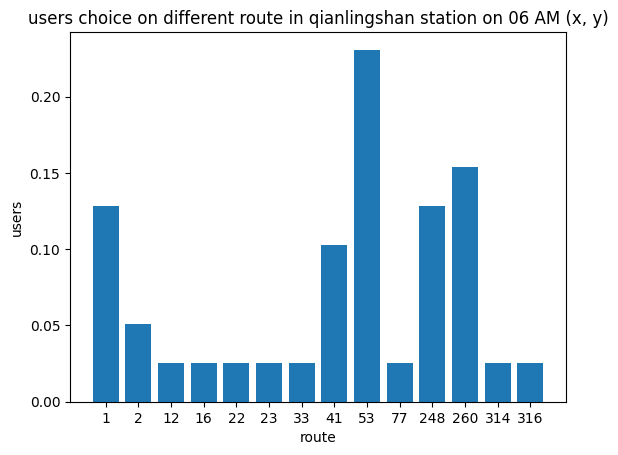

x [  1   2  12  16  22  23  33  41  53  77 248 260 314 316] y [0.12820513 0.05128205 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.1025641  0.23076923 0.02564103 0.12820513 0.15384615
 0.02564103 0.02564103]


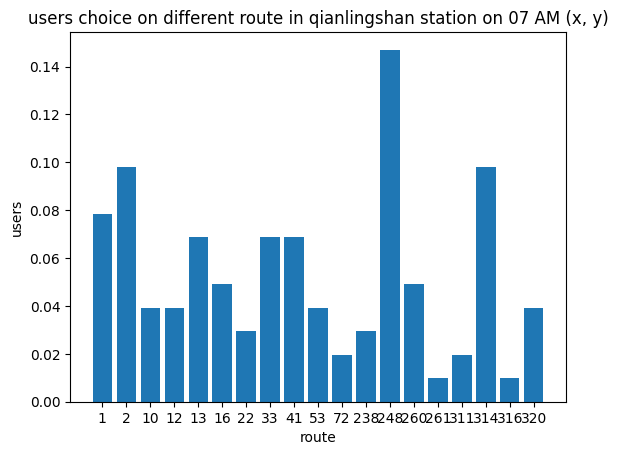

x [  1   2  10  12  13  16  22  33  41  53  72 238 248 260 261 311 314 316
 320] y [0.07843137 0.09803922 0.03921569 0.03921569 0.06862745 0.04901961
 0.02941176 0.06862745 0.06862745 0.03921569 0.01960784 0.02941176
 0.14705882 0.04901961 0.00980392 0.01960784 0.09803922 0.00980392
 0.03921569]


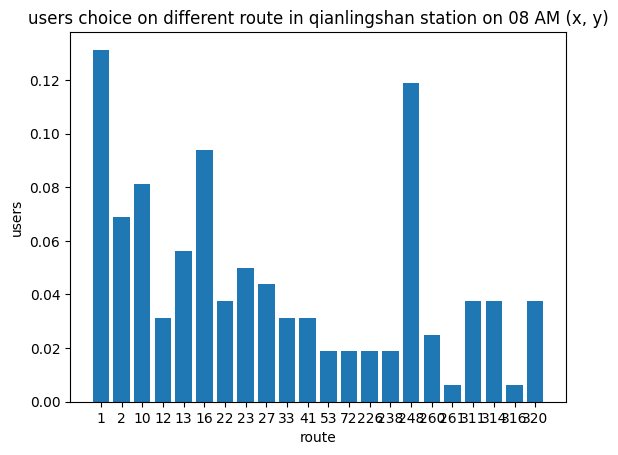

x [  1   2  10  12  13  16  22  23  27  33  41  53  72 226 238 248 260 261
 311 314 316 320] y [0.13125 0.06875 0.08125 0.03125 0.05625 0.09375 0.0375  0.05    0.04375
 0.03125 0.03125 0.01875 0.01875 0.01875 0.01875 0.11875 0.025   0.00625
 0.0375  0.0375  0.00625 0.0375 ]


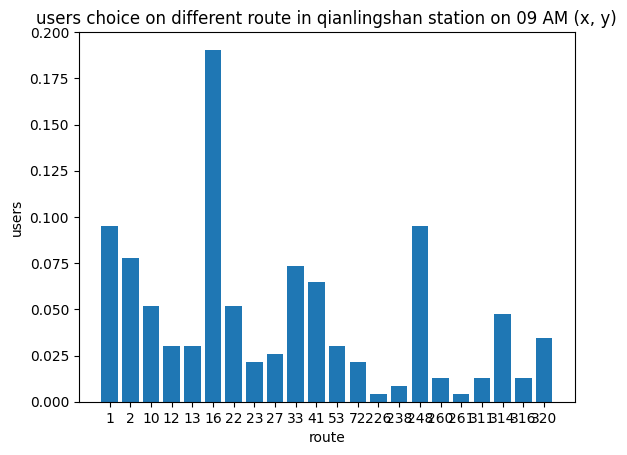

x [  1   2  10  12  13  16  22  23  27  33  41  53  72 226 238 248 260 261
 311 314 316 320] y [0.0952381  0.07792208 0.05194805 0.03030303 0.03030303 0.19047619
 0.05194805 0.02164502 0.02597403 0.07359307 0.06493506 0.03030303
 0.02164502 0.004329   0.00865801 0.0952381  0.01298701 0.004329
 0.01298701 0.04761905 0.01298701 0.03463203]


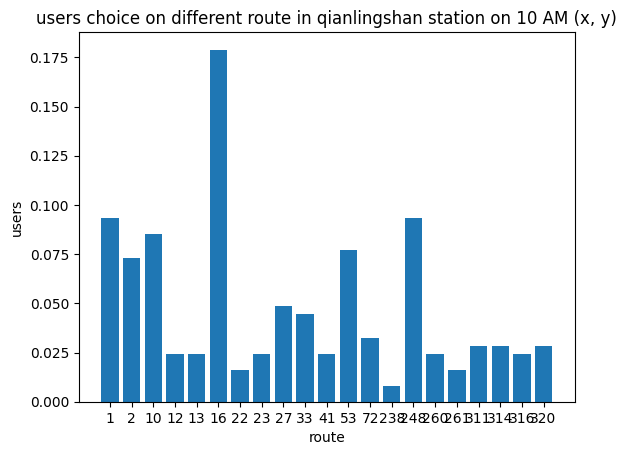

x [  1   2  10  12  13  16  22  23  27  33  41  53  72 238 248 260 261 311
 314 316 320] y [0.09349593 0.07317073 0.08536585 0.02439024 0.02439024 0.17886179
 0.01626016 0.02439024 0.04878049 0.04471545 0.02439024 0.07723577
 0.03252033 0.00813008 0.09349593 0.02439024 0.01626016 0.02845528
 0.02845528 0.02439024 0.02845528]


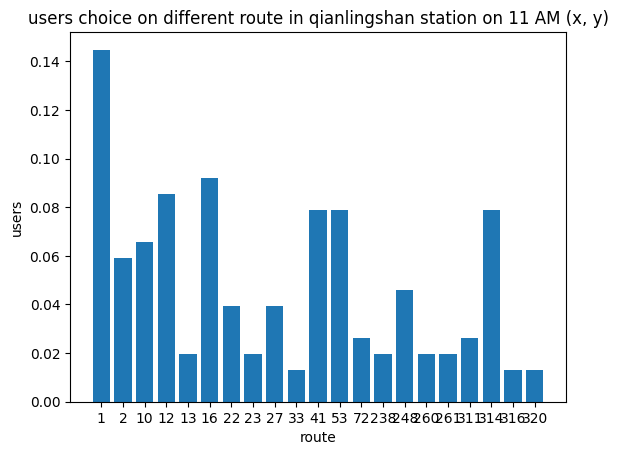

x [  1   2  10  12  13  16  22  23  27  33  41  53  72 238 248 260 261 311
 314 316 320] y [0.14473684 0.05921053 0.06578947 0.08552632 0.01973684 0.09210526
 0.03947368 0.01973684 0.03947368 0.01315789 0.07894737 0.07894737
 0.02631579 0.01973684 0.04605263 0.01973684 0.01973684 0.02631579
 0.07894737 0.01315789 0.01315789]


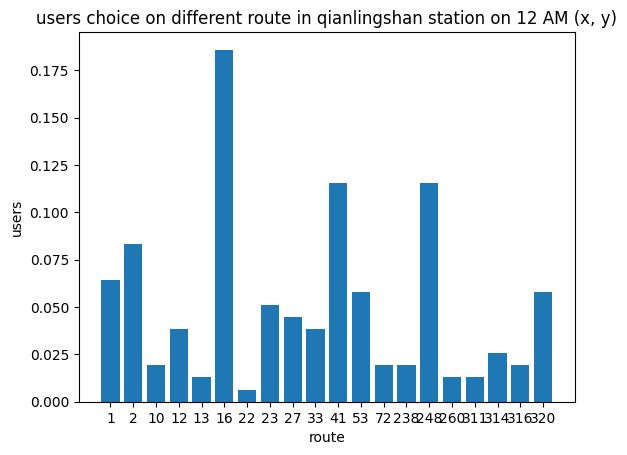

x [  1   2  10  12  13  16  22  23  27  33  41  53  72 238 248 260 311 314
 316 320] y [0.06410256 0.08333333 0.01923077 0.03846154 0.01282051 0.18589744
 0.00641026 0.05128205 0.04487179 0.03846154 0.11538462 0.05769231
 0.01923077 0.01923077 0.11538462 0.01282051 0.01282051 0.02564103
 0.01923077 0.05769231]


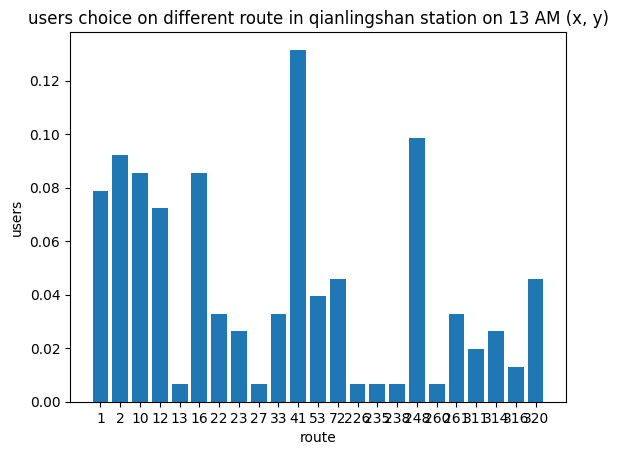

x [  1   2  10  12  13  16  22  23  27  33  41  53  72 226 235 238 248 260
 261 311 314 316 320] y [0.07894737 0.09210526 0.08552632 0.07236842 0.00657895 0.08552632
 0.03289474 0.02631579 0.00657895 0.03289474 0.13157895 0.03947368
 0.04605263 0.00657895 0.00657895 0.00657895 0.09868421 0.00657895
 0.03289474 0.01973684 0.02631579 0.01315789 0.04605263]


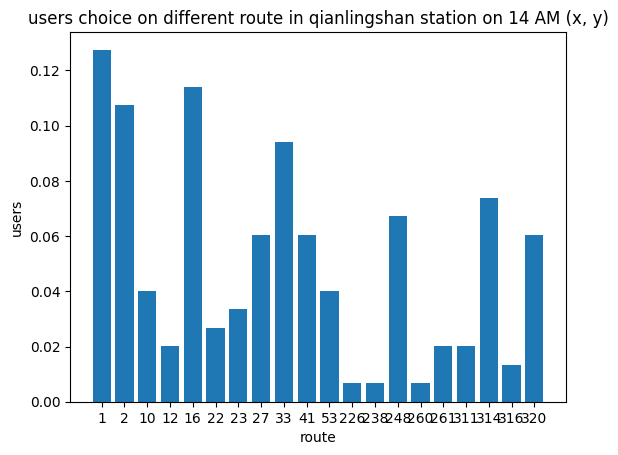

x [  1   2  10  12  16  22  23  27  33  41  53 226 238 248 260 261 311 314
 316 320] y [0.12751678 0.10738255 0.04026846 0.02013423 0.11409396 0.02684564
 0.03355705 0.06040268 0.09395973 0.06040268 0.04026846 0.00671141
 0.00671141 0.06711409 0.00671141 0.02013423 0.02013423 0.0738255
 0.01342282 0.06040268]


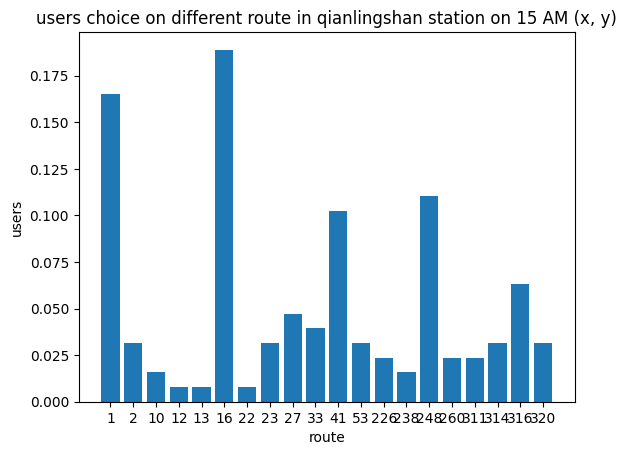

x [  1   2  10  12  13  16  22  23  27  33  41  53 226 238 248 260 311 314
 316 320] y [0.16535433 0.03149606 0.01574803 0.00787402 0.00787402 0.18897638
 0.00787402 0.03149606 0.04724409 0.03937008 0.1023622  0.03149606
 0.02362205 0.01574803 0.11023622 0.02362205 0.02362205 0.03149606
 0.06299213 0.03149606]


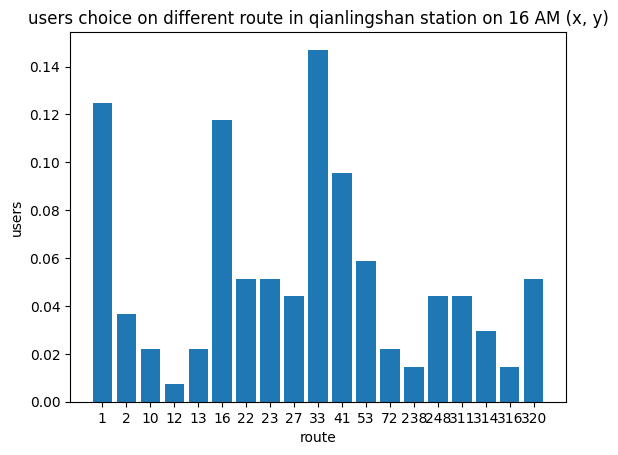

x [  1   2  10  12  13  16  22  23  27  33  41  53  72 238 248 311 314 316
 320] y [0.125      0.03676471 0.02205882 0.00735294 0.02205882 0.11764706
 0.05147059 0.05147059 0.04411765 0.14705882 0.09558824 0.05882353
 0.02205882 0.01470588 0.04411765 0.04411765 0.02941176 0.01470588
 0.05147059]


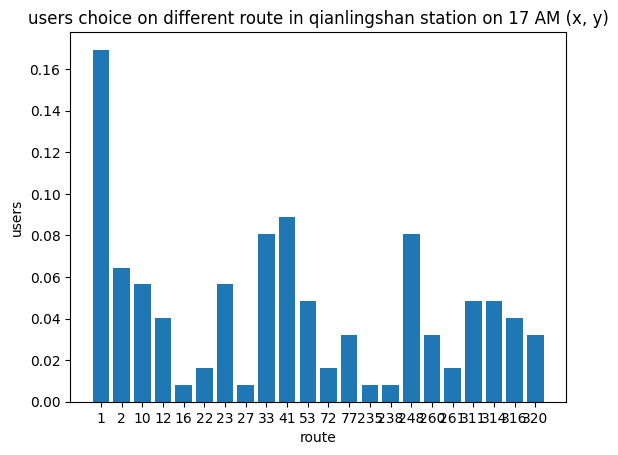

x [  1   2  10  12  16  22  23  27  33  41  53  72  77 235 238 248 260 261
 311 314 316 320] y [0.16935484 0.06451613 0.05645161 0.04032258 0.00806452 0.01612903
 0.05645161 0.00806452 0.08064516 0.08870968 0.0483871  0.01612903
 0.03225806 0.00806452 0.00806452 0.08064516 0.03225806 0.01612903
 0.0483871  0.0483871  0.04032258 0.03225806]


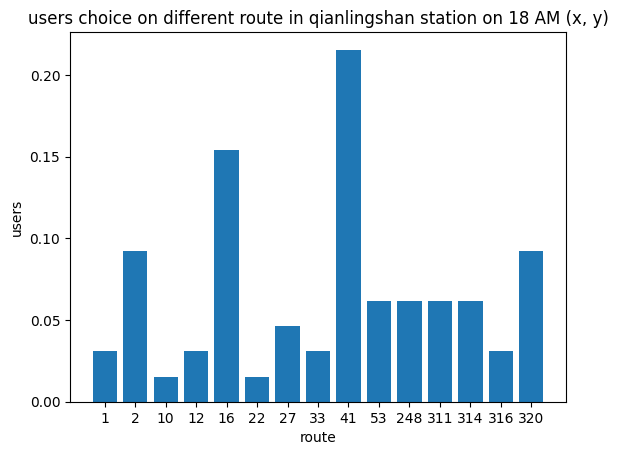

x [  1   2  10  12  16  22  27  33  41  53 248 311 314 316 320] y [0.03076923 0.09230769 0.01538462 0.03076923 0.15384615 0.01538462
 0.04615385 0.03076923 0.21538462 0.06153846 0.06153846 0.06153846
 0.06153846 0.03076923 0.09230769]


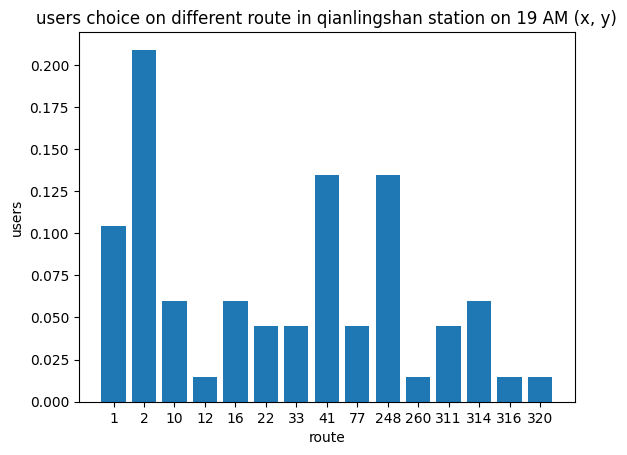

x [  1   2  10  12  16  22  33  41  77 248 260 311 314 316 320] y [0.10447761 0.20895522 0.05970149 0.01492537 0.05970149 0.04477612
 0.04477612 0.13432836 0.04477612 0.13432836 0.01492537 0.04477612
 0.05970149 0.01492537 0.01492537]


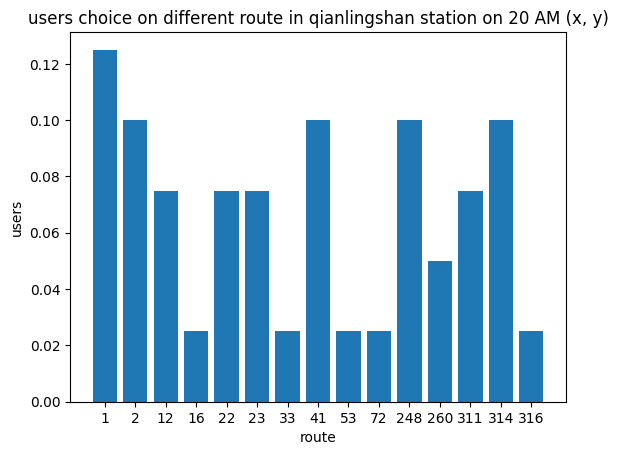

x [  1   2  12  16  22  23  33  41  53  72 248 260 311 314 316] y [0.125 0.1   0.075 0.025 0.075 0.075 0.025 0.1   0.025 0.025 0.1   0.05
 0.075 0.1   0.025]


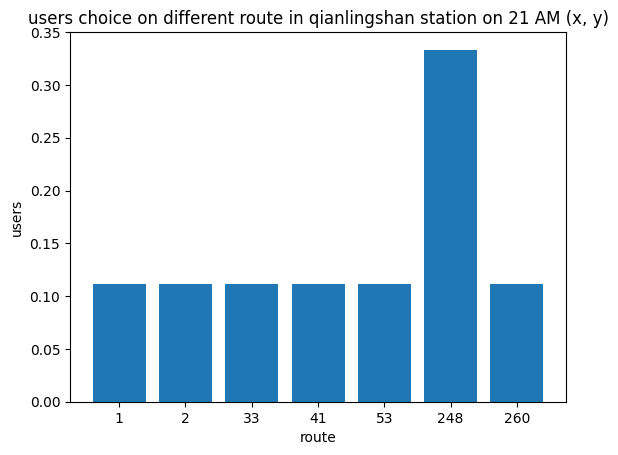

x [  1   2  33  41  53 248 260] y [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.33333333
 0.11111111]


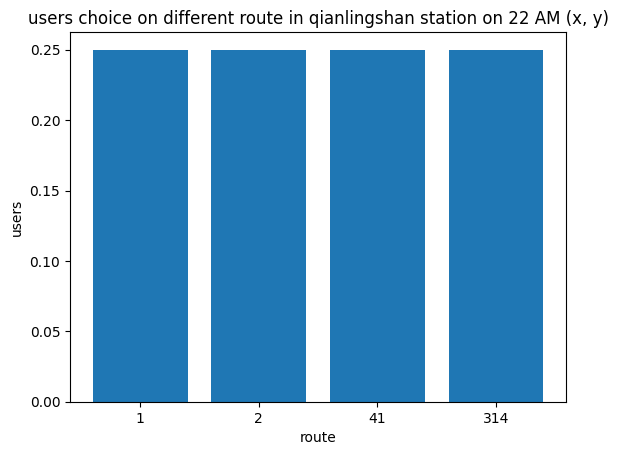

x [  1   2  41 314] y [0.25 0.25 0.25 0.25]


In [58]:
#station_2_id['黔灵山公园'] 1414
qianlingshan_0929_data = same_station_different_hour_and_line[same_station_different_hour_and_line['this_od_trip_start_station']==1414].reset_index(drop=True)
qianlingshan_0929_data
# 对DataFrame进行groupby并计算每个组的总和
qianlingshan_0929_data_grouped_sum = qianlingshan_0929_data.groupby('hour')['nums'].transform('sum')
qianlingshan_0929_data_grouped_sum
# 计算每行的值占总和的比例
qianlingshan_0929_data['nums_proportion'] = qianlingshan_0929_data['nums'] / qianlingshan_0929_data_grouped_sum
qianlingshan_0929_data
#qianlingshan_0929_data = qianlingshan_0929_data[qianlingshan_0929_data['hour']=='06'].reset_index(drop=True)
#qianlingshan_0929_data
for i in qianlingshan_0929_data['hour'].unique():
    qianlingshan_0929_data_hour_06 = qianlingshan_0929_data[qianlingshan_0929_data['hour']==i].reset_index(drop=True)
    y = qianlingshan_0929_data_hour_06['nums_proportion'].values.tolist()
    x = qianlingshan_0929_data_hour_06['this_od_by_line'].values.tolist()
    plt.bar(range(len(x)), y)
    plt.xticks(range(len(x)),x)
    title = f"users choice on different route in qianlingshan station on {i} AM (x, y)"
    plt.title(title)
    plt.xlabel('route')
    plt.ylabel('users')
    plt.savefig(f'./figures/people_choice_different_line_on_{i}am_qianlingshan_histogram.svg', format='svg')
    plt.show()
    print('x',np.array(x),'y',np.array(y))

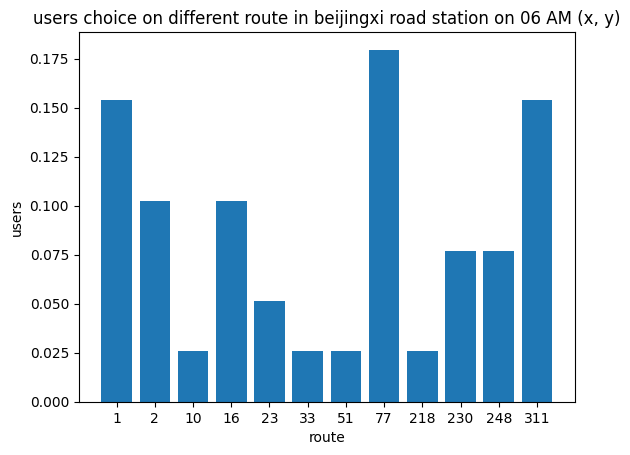

x [  1   2  10  16  23  33  51  77 218 230 248 311] y [0.15384615 0.1025641  0.02564103 0.1025641  0.05128205 0.02564103
 0.02564103 0.17948718 0.02564103 0.07692308 0.07692308 0.15384615]


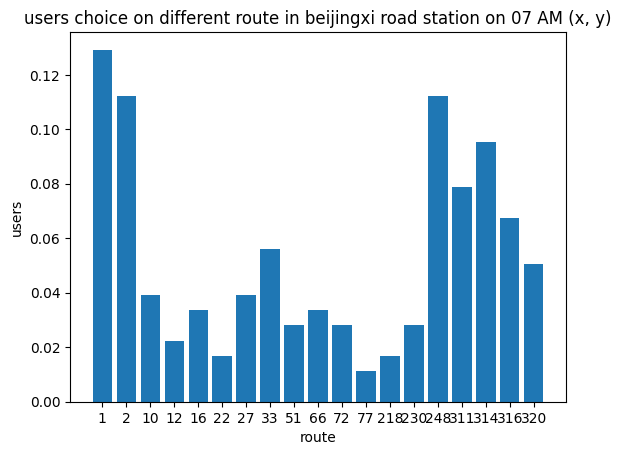

x [  1   2  10  12  16  22  27  33  51  66  72  77 218 230 248 311 314 316
 320] y [0.12921348 0.11235955 0.03932584 0.02247191 0.03370787 0.01685393
 0.03932584 0.05617978 0.02808989 0.03370787 0.02808989 0.01123596
 0.01685393 0.02808989 0.11235955 0.07865169 0.09550562 0.06741573
 0.0505618 ]


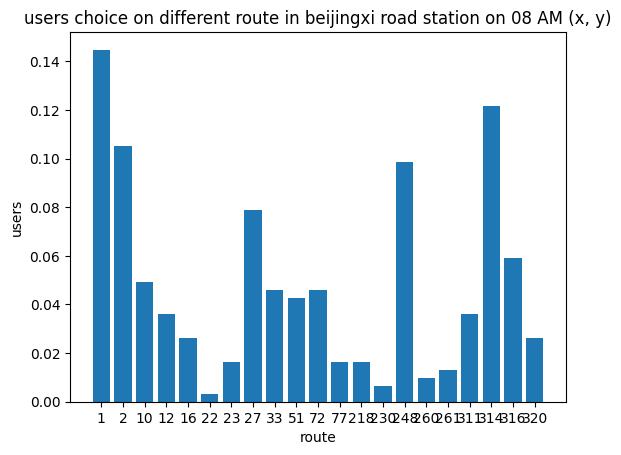

x [  1   2  10  12  16  22  23  27  33  51  72  77 218 230 248 260 261 311
 314 316 320] y [0.14473684 0.10526316 0.04934211 0.03618421 0.02631579 0.00328947
 0.01644737 0.07894737 0.04605263 0.04276316 0.04605263 0.01644737
 0.01644737 0.00657895 0.09868421 0.00986842 0.01315789 0.03618421
 0.12171053 0.05921053 0.02631579]


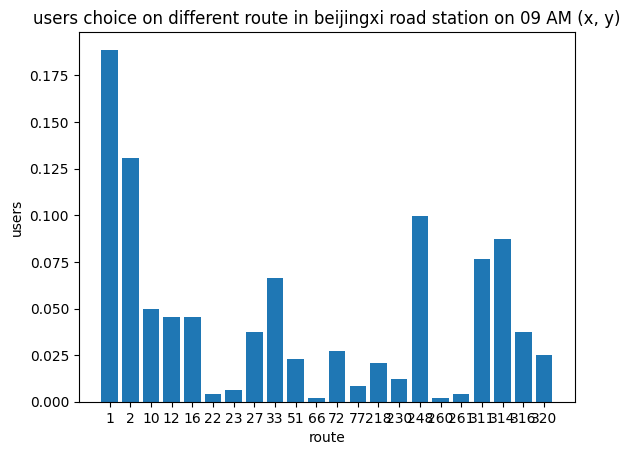

x [  1   2  10  12  16  22  23  27  33  51  66  72  77 218 230 248 260 261
 311 314 316 320] y [0.18879668 0.13070539 0.04979253 0.04564315 0.04564315 0.00414938
 0.00622407 0.0373444  0.06639004 0.02282158 0.00207469 0.02697095
 0.00829876 0.02074689 0.01244813 0.09958506 0.00207469 0.00414938
 0.07676349 0.08713693 0.0373444  0.02489627]


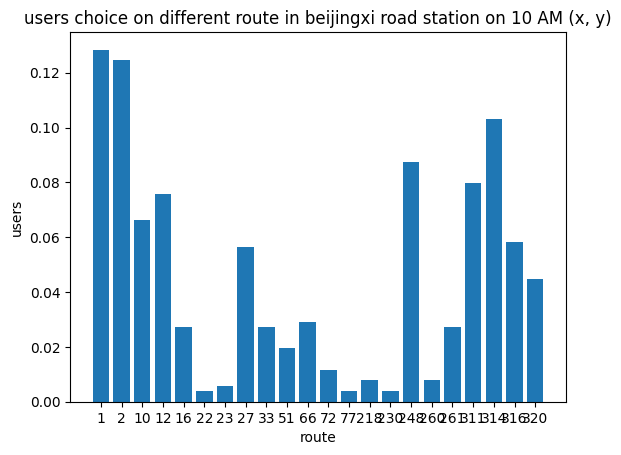

x [  1   2  10  12  16  22  23  27  33  51  66  72  77 218 230 248 260 261
 311 314 316 320] y [0.12840467 0.12451362 0.06614786 0.07587549 0.02723735 0.00389105
 0.00583658 0.05642023 0.02723735 0.01945525 0.02918288 0.01167315
 0.00389105 0.0077821  0.00389105 0.08754864 0.0077821  0.02723735
 0.07976654 0.10311284 0.05836576 0.04474708]


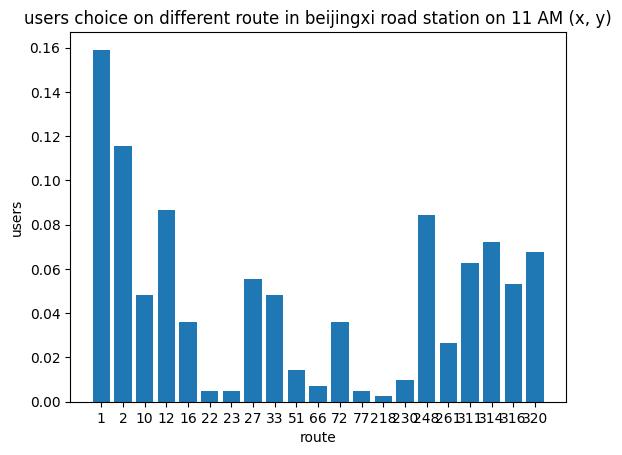

x [  1   2  10  12  16  22  23  27  33  51  66  72  77 218 230 248 261 311
 314 316 320] y [0.15903614 0.11566265 0.04819277 0.08674699 0.03614458 0.00481928
 0.00481928 0.05542169 0.04819277 0.01445783 0.00722892 0.03614458
 0.00481928 0.00240964 0.00963855 0.08433735 0.02650602 0.0626506
 0.07228916 0.05301205 0.06746988]


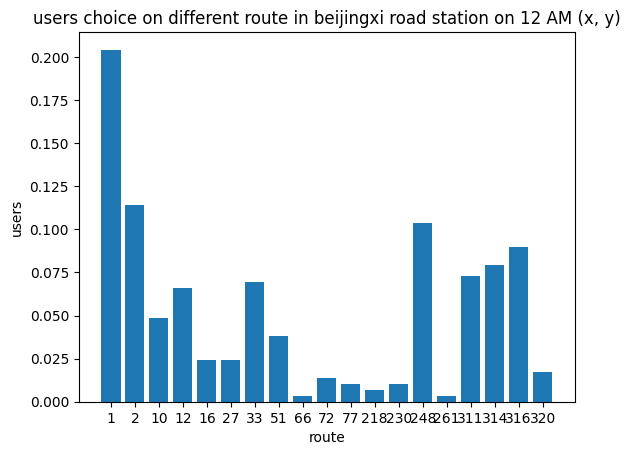

x [  1   2  10  12  16  27  33  51  66  72  77 218 230 248 261 311 314 316
 320] y [0.20415225 0.11418685 0.04844291 0.06574394 0.02422145 0.02422145
 0.06920415 0.03806228 0.00346021 0.01384083 0.01038062 0.00692042
 0.01038062 0.10380623 0.00346021 0.07266436 0.07958478 0.0899654
 0.01730104]


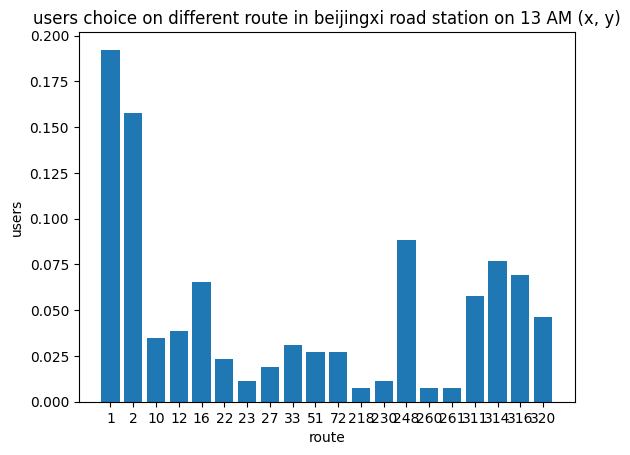

x [  1   2  10  12  16  22  23  27  33  51  72 218 230 248 260 261 311 314
 316 320] y [0.19230769 0.15769231 0.03461538 0.03846154 0.06538462 0.02307692
 0.01153846 0.01923077 0.03076923 0.02692308 0.02692308 0.00769231
 0.01153846 0.08846154 0.00769231 0.00769231 0.05769231 0.07692308
 0.06923077 0.04615385]


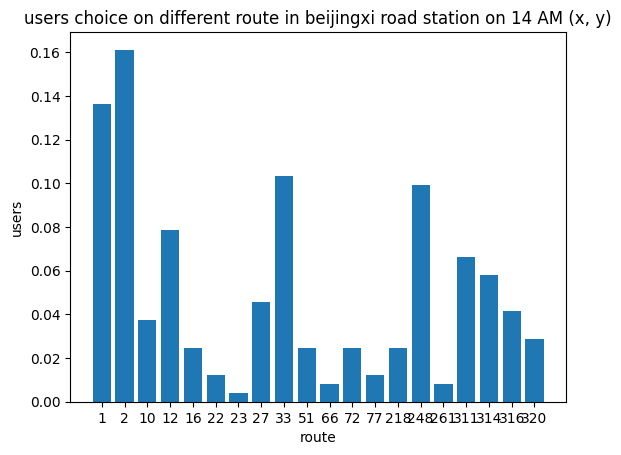

x [  1   2  10  12  16  22  23  27  33  51  66  72  77 218 248 261 311 314
 316 320] y [0.13636364 0.16115702 0.03719008 0.0785124  0.02479339 0.01239669
 0.00413223 0.04545455 0.10330579 0.02479339 0.00826446 0.02479339
 0.01239669 0.02479339 0.09917355 0.00826446 0.0661157  0.05785124
 0.04132231 0.02892562]


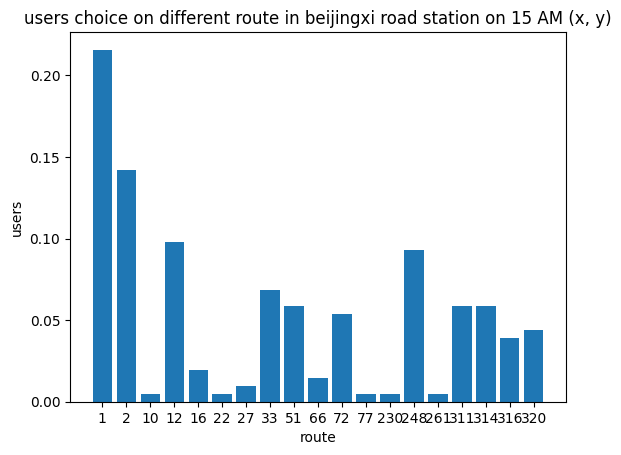

x [  1   2  10  12  16  22  27  33  51  66  72  77 230 248 261 311 314 316
 320] y [0.21568627 0.14215686 0.00490196 0.09803922 0.01960784 0.00490196
 0.00980392 0.06862745 0.05882353 0.01470588 0.05392157 0.00490196
 0.00490196 0.09313725 0.00490196 0.05882353 0.05882353 0.03921569
 0.04411765]


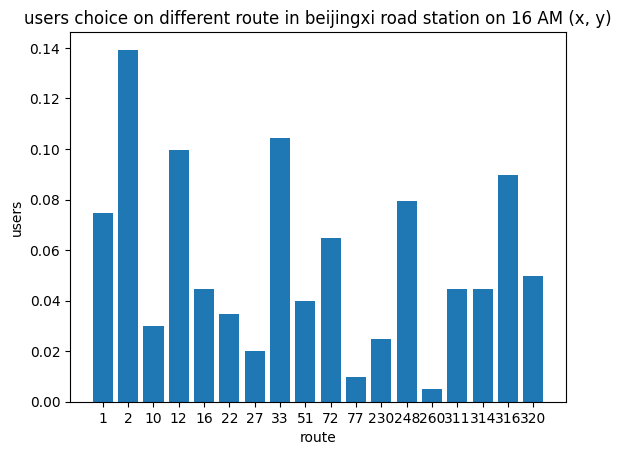

x [  1   2  10  12  16  22  27  33  51  72  77 230 248 260 311 314 316 320] y [0.07462687 0.13930348 0.02985075 0.09950249 0.04477612 0.03482587
 0.0199005  0.10447761 0.039801   0.06467662 0.00995025 0.02487562
 0.07960199 0.00497512 0.04477612 0.04477612 0.08955224 0.04975124]


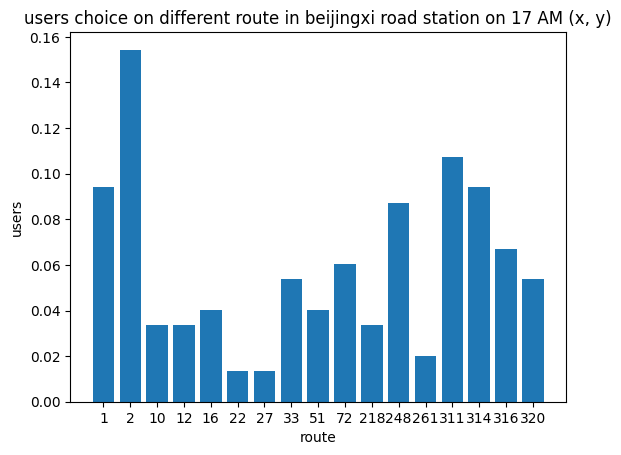

x [  1   2  10  12  16  22  27  33  51  72 218 248 261 311 314 316 320] y [0.09395973 0.15436242 0.03355705 0.03355705 0.04026846 0.01342282
 0.01342282 0.05369128 0.04026846 0.06040268 0.03355705 0.08724832
 0.02013423 0.10738255 0.09395973 0.06711409 0.05369128]


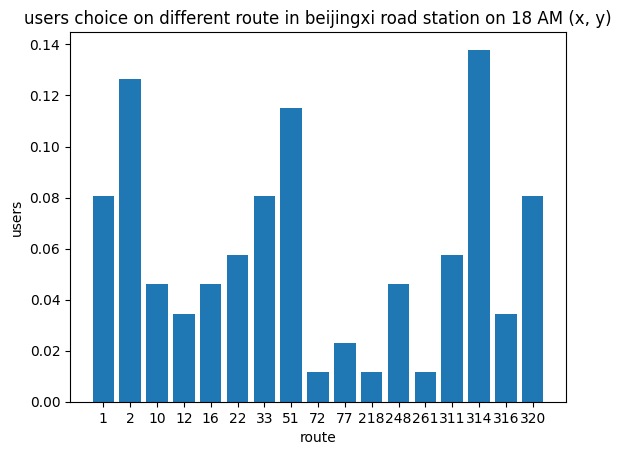

x [  1   2  10  12  16  22  33  51  72  77 218 248 261 311 314 316 320] y [0.08045977 0.12643678 0.04597701 0.03448276 0.04597701 0.05747126
 0.08045977 0.11494253 0.01149425 0.02298851 0.01149425 0.04597701
 0.01149425 0.05747126 0.13793103 0.03448276 0.08045977]


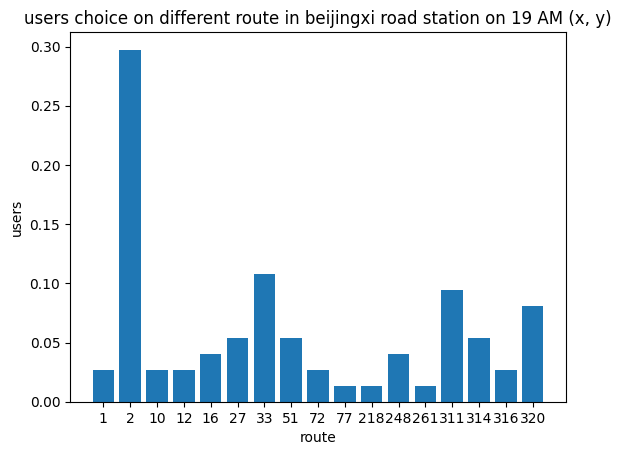

x [  1   2  10  12  16  27  33  51  72  77 218 248 261 311 314 316 320] y [0.02702703 0.2972973  0.02702703 0.02702703 0.04054054 0.05405405
 0.10810811 0.05405405 0.02702703 0.01351351 0.01351351 0.04054054
 0.01351351 0.09459459 0.05405405 0.02702703 0.08108108]


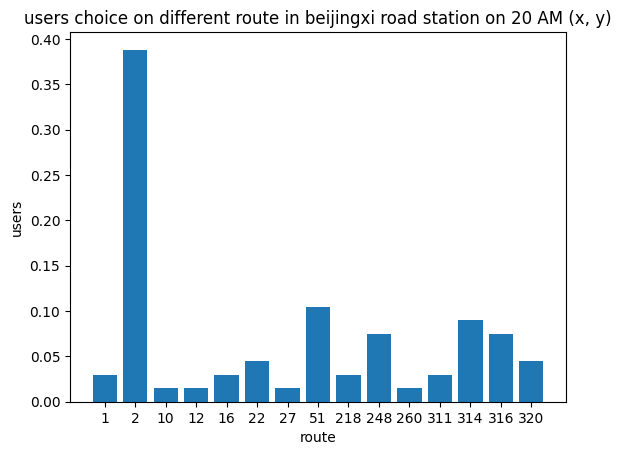

x [  1   2  10  12  16  22  27  51 218 248 260 311 314 316 320] y [0.02985075 0.3880597  0.01492537 0.01492537 0.02985075 0.04477612
 0.01492537 0.10447761 0.02985075 0.07462687 0.01492537 0.02985075
 0.08955224 0.07462687 0.04477612]


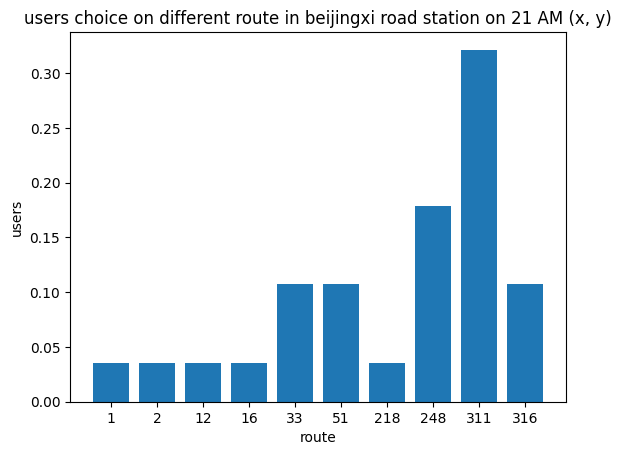

x [  1   2  12  16  33  51 218 248 311 316] y [0.03571429 0.03571429 0.03571429 0.03571429 0.10714286 0.10714286
 0.03571429 0.17857143 0.32142857 0.10714286]


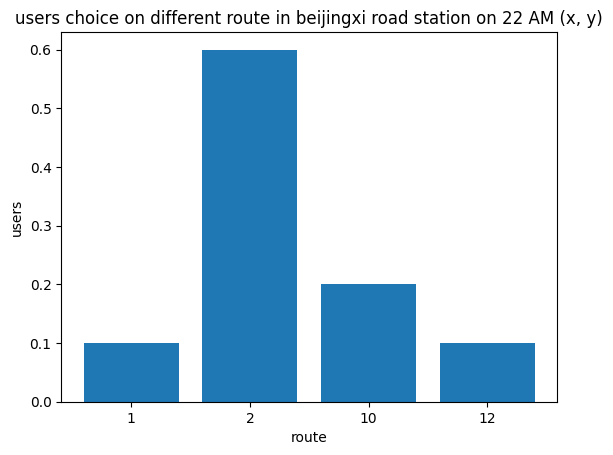

x [ 1  2 10 12] y [0.1 0.6 0.2 0.1]


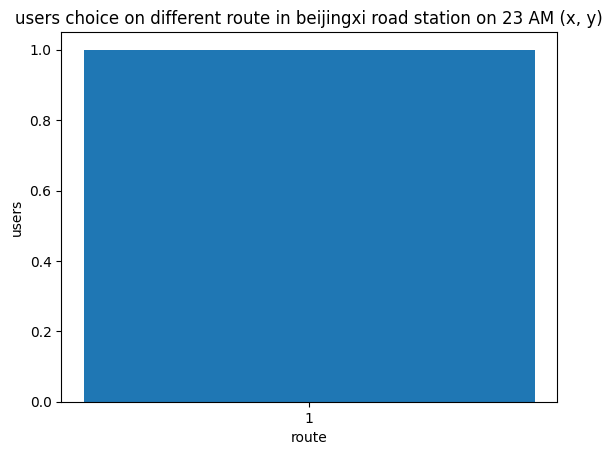

x [1] y [1.]


In [50]:
# 对DataFrame进行groupby并计算每个组的总和
beijing_xilukou_0929_data_grouped_sum = beijing_xilukou_0929_data.groupby('hour')['nums'].transform('sum')
beijing_xilukou_0929_data_grouped_sum
# 计算每行的值占总和的比例
beijing_xilukou_0929_data['nums_proportion'] = beijing_xilukou_0929_data['nums'] / beijing_xilukou_0929_data_grouped_sum
beijing_xilukou_0929_data
beijing_xilukou_0929_data_hour_06 = beijing_xilukou_0929_data[beijing_xilukou_0929_data['hour']=='06'].reset_index(drop=True)
beijing_xilukou_0929_data_hour_06
import matplotlib.pyplot as plt
#可以统计一下每个人的乘车次数直方图
y = beijing_xilukou_0929_data_hour_06['nums_proportion'].values.tolist()
x = beijing_xilukou_0929_data_hour_06['this_od_by_line'].values.tolist()
# 创建直方图
plt.bar(range(len(x)), y)
# 设置横轴刻度标签为自定义的类别名称
plt.xticks(range(len(x)),x)
# 添加标题和标签
plt.title('users choice on different route in beijingxi road station on 6 AM (x, y)')
plt.xlabel('route')
plt.ylabel('users')
# 保存图形为SVG格式
plt.savefig('./figures/people_choice_different_line_on_6am_histogram.svg', format='svg')
# 显示图形
plt.show()
'x',np.array(x),'y',np.array(y)
for i in beijing_xilukou_0929_data['hour'].unique():
    beijing_xilukou_0929_data_hour_06 = beijing_xilukou_0929_data[beijing_xilukou_0929_data['hour']==i].reset_index(drop=True)
    y = beijing_xilukou_0929_data_hour_06['nums_proportion'].values.tolist()
    x = beijing_xilukou_0929_data_hour_06['this_od_by_line'].values.tolist()
    plt.bar(range(len(x)), y)
    plt.xticks(range(len(x)),x)
    title = f"users choice on different route in beijingxi road station on {i} AM (x, y)"
    plt.title(title)
    plt.xlabel('route')
    plt.ylabel('users')
    plt.savefig(f'./figures/people_choice_different_line_on_{i}am_histogram.svg', format='svg')
    plt.show()
    print('x',np.array(x),'y',np.array(y))

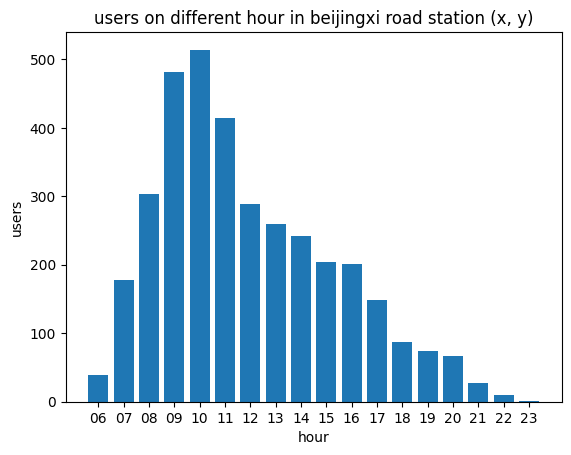

('x',
 array(['06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16',
        '17', '18', '19', '20', '21', '22', '23'], dtype='<U2'),
 'y',
 array([ 39, 178, 304, 482, 514, 415, 289, 260, 242, 204, 201, 149,  87,
         74,  67,  28,  10,   1]))

In [48]:
beijing_xilukou_0929_hour_data = beijing_xilukou_0929_data.groupby('hour').agg({'nums':list}).reset_index()
beijing_xilukou_0929_hour_data['all_nums']=beijing_xilukou_0929_hour_data['nums'].apply(lambda x:sum(x))
beijing_xilukou_0929_hour_data
import matplotlib.pyplot as plt
#可以统计一下每个人的乘车次数直方图
users_demand = beijing_xilukou_0929_hour_data['all_nums'].values.tolist()
hours = beijing_xilukou_0929_hour_data['hour'].values.tolist()
# 创建直方图
plt.bar(range(len(hours)), users_demand)
# 设置横轴刻度标签为自定义的类别名称
plt.xticks(range(len(hours)),hours)
# 添加标题和标签
plt.title('users on different hour in beijingxi road station (x, y)')
plt.xlabel('hour')
plt.ylabel('users')
# 保存图形为SVG格式
plt.savefig('./figures/people_on_different_hour_histogram.svg', format='svg')
# 显示图形
plt.show()
'x',np.array(hours),'y',np.array(users_demand)

# 总结
对于多程trip可以找到最后一程的终点站，所以我们可以找到在能观测到的od对的情况下的人流分布。
比如说各个站点的净流入和流出是多少。但是还有一半的行程是不能识别出od对的，所以导致对于这些旅程的公交走廊识别存在困难。
同样也可以对这些行程去估计回去的od对。
对于多程的，可以标记处起点站，和倒数第二个终点站，也就是最后一程的起点站。然后去估计实际的终点站是多少。

基于可观测的这些数据，去估计那些不可观测的可能路线，就可以统计出各个时间段，走向各个方向的人流的概率，从而对各个站点的乘客数量做出估计。


In [ ]:
can_used_od_trips=[]
def find_leave_station(sorted_index_array:np.ndarray,specified_indices:list):
    # 找到指定索引组中在排序数组中的位置
    positions = [sorted_index_array.index(idx) for idx in specified_indices]
    return sorted_index_array[min(positions)]
for row_index in range(len(trip_great_than_2)):
    trip_list = trip_great_than_2[row_index:row_index+1]['trip'].values[0]
    sorted_trips_list = sorted(trip_list,key=lambda x:x[0],reverse=False)
    for trip_index in range(len(sorted_trips_list)-1):
        this_time,this_line,this_station_id = sorted_trips_list[trip_index]
        next_time,next_line,next_station_id = sorted_trips_list[trip_index+1]
        try:
            this_line_station_name = road_line_station_structure_setting[this_line]['stations'][this_station_id]
            this_line_station_id = station_2_id[this_line_station_name]
        
            all_possible_leave_stations = road_line_station_structure_setting[this_line]['all_stations']
            all_possible_leave_stations_index = [station_2_id[station] for station in all_possible_leave_stations]
        
            next_line_station_name = road_line_station_structure_setting[next_line]['stations'][next_station_id]
            next_line_station_id = station_2_id[next_line_station_name]
            distance_2_next_line_station_ndarray  = station_distance_rank_index_list[next_line_station_id]
            leave_station = find_leave_station(distance_2_next_line_station_ndarray.tolist(),all_possible_leave_stations_index)
            od_trip = (this_line_station_id,this_time,this_line,next_line_station_id)
            can_used_od_trips.append(od_trip)
        except:
            continue

In [ ]:
can_used_od_trips[0:5]
print(id_2_station['795'],id_2_station['1416'])
print(road_line_station_structure_setting[7]['all_stations'])
print(bus_station_dataframe[bus_station_dataframe['line_identity']==7]['station_name'])

In [ ]:
#将可用的od对转化为dataframe：这样就可以使用dataframe进行聚类
#can_used_od_trips[0:5]
can_used_od_trips_dataframe = pd.DataFrame(columns=['start_station_id','time','line','end_station_id'])
for trip_index in range(len(can_used_od_trips)):
    start_station_id,time,line,end_station_id=can_used_od_trips[trip_index]
    can_used_od_trips_dataframe.loc[len(can_used_od_trips_dataframe)] = \
    {'start_station_id':start_station_id, \
                                         'time':time, \
                                         'line':line, \
                                         'end_station_id':end_station_id}

In [ ]:
len(can_used_od_trips)
#一共有169099可以确定的od对数据

In [ ]:
can_used_od_trips_dataframe['hour']= \
can_used_od_trips_dataframe['time'].apply(lambda x:x.split(':')[0])
can_used_od_trips_dataframe['minu']= \
can_used_od_trips_dataframe['time'].apply(lambda x:x.split(':')[1])

In [ ]:
can_used_od_trips_dataframe

In [ ]:
can_used_od_trips_dataframe.to_json('./can_used_od_trips_dataframe.json', orient='records')